# Multi-Class Classification with Pytorch

Today, we will

- learn how to build and train a model using Pytorch
- learn about MNIST dataset
- experiment with hyper-parameters tuning


Model development `Life-cycle`:
1. Prepare the `data`
2. Define the `model architecture` **
3. Train the model **
4. Evaluate the model
5. Deploy the model

** : what we are going to focus today !

In [2]:
# For our puffer surver we need to browse via a proxy!!
import os
# Set HTTP and HTTPS proxy
# os.environ['http_proxy'] = 'http://192.41.170.23:3128'
# os.environ['https_proxy'] = 'http://192.41.170.23:3128'

In [3]:
# !pip3 install tensorboard
# from torch.utils.tensorboard import SummaryWriter
# %load_ext tensorboard

In [4]:
import numpy as np
import torch
import matplotlib.pyplot as plt

In [5]:
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset


## Lets download our data

In [6]:
# load the training data
transform = torchvision.transforms.Compose([
                                          torchvision.transforms.ToTensor(),
                                          torchvision.transforms.Normalize(mean=0.1307, std=0.3081)
                                          ])

train_ds = torchvision.datasets.MNIST(root='.', train=True, download=True, transform=transform)
test_ds = torchvision.datasets.MNIST(root='.', train=False, download=True, transform=transform)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:04<00:00, 2328140.60it/s]


Extracting .\MNIST\raw\train-images-idx3-ubyte.gz to .\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 112626.32it/s]


Extracting .\MNIST\raw\train-labels-idx1-ubyte.gz to .\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:02<00:00, 796151.27it/s] 


Extracting .\MNIST\raw\t10k-images-idx3-ubyte.gz to .\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 16618.13it/s]

Extracting .\MNIST\raw\t10k-labels-idx1-ubyte.gz to .\MNIST\raw



In [7]:
print(len(train_ds))
print(len(test_ds))

60000
10000


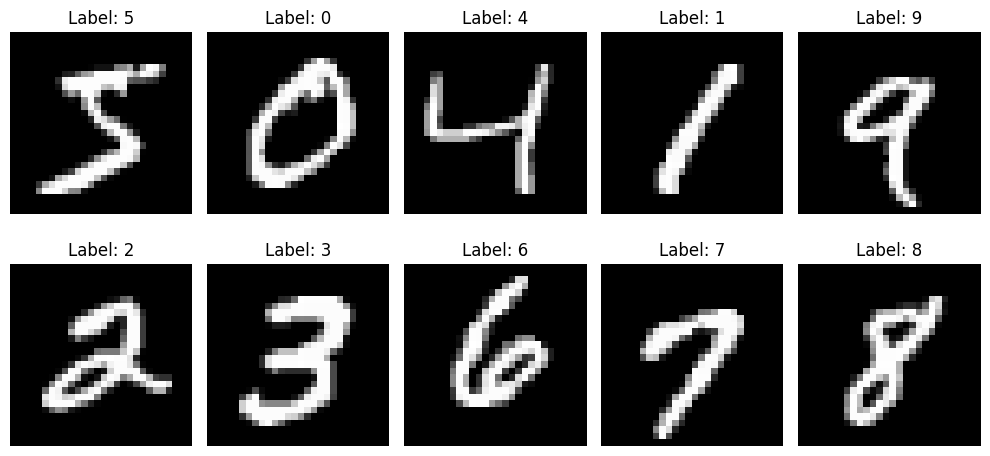

In [8]:
# Create a dictionary to store one image per label
images_per_label = {}

# Loop through the dataset to find one image per label
for img, label in train_ds:
    if label not in images_per_label:
        images_per_label[label] = img
    if len(images_per_label) == 10:  # Break the loop once we have all labels
        break

# Plot the images, one per label
fig, axes = plt.subplots(2, 5, figsize=(10, 5))

for i, (label, img) in enumerate(images_per_label.items()):
    ax = axes[i // 5, i % 5]
    ax.imshow(img.squeeze(), cmap='gray')
    ax.set_title(f'Label: {label}')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [9]:
# Hyperparameters
lr = 0.01
batch_size = 64
num_epoch = 10
classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [10]:
train_ds = list(train_ds)[:10000]
train_loader = torch.utils.data.DataLoader(train_ds, 
                                           batch_size=batch_size, 
                                           shuffle=True, 
                                           num_workers=2)

test_loader = torch.utils.data.DataLoader(test_ds, 
                                          batch_size=batch_size, 
                                          shuffle=False, 
                                          num_workers=2)

In [11]:
train_ds[0][0].shape

torch.Size([1, 28, 28])

# 1. Define the model

# Convolutional Neural Network (CNN)

In [12]:
import torch.nn as nn
import torch.nn.functional as F

In [13]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


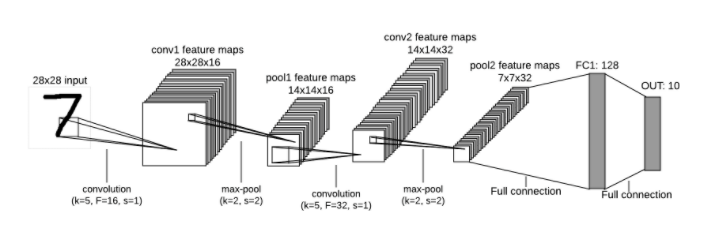

**The model architecture that we are going to build**

Input => conv1 => maxpooling => FC => output

In [14]:
class MyCNN(nn.Module):            # define own MyCNN which inherits nn.Module as a base class
  def __init__(self):
    super(MyCNN, self).__init__()
    self.conv1 = nn.Conv2d(1, 16, kernel_size=3) # conv2d(in_channel, out_channel, kernel_size, stride=1, padding=0, bias=True)
    # (28+2*0-3)/1 + 1 = 26
    self.maxpool = nn.MaxPool2d(2)
    # (26/2)
    self.fc1 = nn.Linear(13*13*16, 10) # Flattened output from convolution followed by pooling layer

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.maxpool(x)
    x = torch.flatten(x,1) # feature maps flattened to 1D tensor output. second dimension (1) refers to flattening across the features, leaving the batch dimension intact.
    x = self.fc1(x)        # produces an output of size 10 (one score for each class)
    return x, F.log_softmax(x, dim=1) # raw output from x (logits), log of softmax of x which normalizes the logits into prob.

In [15]:
cnn_model = MyCNN()
cnn_model = cnn_model.to(device)
optimizer = torch.optim.SGD(cnn_model.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss()

In [16]:
print(cnn_model)

MyCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2704, out_features=10, bias=True)
)


In [17]:
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

def train():
    cnn_model.train()                                      # sets model to training mode (dropout and batchnorm behaves in this mode)
    train_corr, train_total, train_running_loss = 0, 0, 0  # counters for tracting trainning accuracy, total examples, running loss

    for step, (data, y) in enumerate(train_loader):        # loops over batch of data in train_loader
        data, y = data.to(device), y.to(device)
        optimizer.zero_grad()                                # resets gradients to prevent accumulation
        _, logits = cnn_model(data)                          # gets the logits 
        loss = loss_fn(logits, y)                            # calculates loss comparing with true label
        loss.backward()                                      # back propagation is performed to compute gradients
        optimizer.step()                                     # optimizer updates model params

        y_pred = torch.argmax(logits, 1)                     # selects the predicted class (the index with the highest value)
        train_corr += torch.sum(torch.eq(y_pred, y).float()).item()      # counts correct predictions
        train_total += len(data)                             # tracks total no. of samples
        train_running_loss += loss.item()                    # accumulates loss
    
    # Calculate average loss and accuracy for this epoch
    epoch_loss = train_running_loss / len(train_loader)
    epoch_accuracy = train_corr / train_total

    # Append to lists for plotting
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    print(f'Epoch [{epoch+1}] Train Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')
    
####################################################################################################################
   
def test():
    cnn_model.eval()                                        # sets model to evalutaion mode
    test_corr, test_total, test_running_loss = 0, 0, 0
    with torch.no_grad():
        for step, (data, y) in enumerate(test_loader):
            data, y = data.to(device), y.to(device)
            _, logits = cnn_model(data)
            loss = loss_fn(logits, y)
            y_pred = torch.argmax(logits, 1)
            test_corr += torch.sum(torch.eq(y_pred, y).float()).item()
            test_total += len(data)
            test_running_loss += loss.item()
    # Calculate average loss and accuracy for this epoch
    epoch_loss = test_running_loss / len(test_loader)
    epoch_accuracy = test_corr / test_total

    # Append to lists for plotting
    test_losses.append(epoch_loss)
    test_accuracies.append(epoch_accuracy)

    print(f'Epoch [{epoch+1}] Test Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')

In [18]:
for epoch in range(num_epoch):
  print(f"--------- Train EPOCH {epoch} -------------")
  train()
  print(f"--------- Test EPOCH {epoch} -------------")
  test()

--------- Train EPOCH 0 -------------
Epoch [1] Train Loss: 0.6240, Accuracy: 0.8342
--------- Test EPOCH 0 -------------
Epoch [1] Test Loss: 0.3933, Accuracy: 0.8830
--------- Train EPOCH 1 -------------
Epoch [2] Train Loss: 0.3497, Accuracy: 0.8993
--------- Test EPOCH 1 -------------
Epoch [2] Test Loss: 0.3918, Accuracy: 0.8771
--------- Train EPOCH 2 -------------
Epoch [3] Train Loss: 0.3095, Accuracy: 0.9121
--------- Test EPOCH 2 -------------
Epoch [3] Test Loss: 0.3103, Accuracy: 0.9095
--------- Train EPOCH 3 -------------
Epoch [4] Train Loss: 0.2816, Accuracy: 0.9197
--------- Test EPOCH 3 -------------
Epoch [4] Test Loss: 0.3237, Accuracy: 0.9056
--------- Train EPOCH 4 -------------
Epoch [5] Train Loss: 0.2673, Accuracy: 0.9259
--------- Test EPOCH 4 -------------
Epoch [5] Test Loss: 0.3176, Accuracy: 0.9062
--------- Train EPOCH 5 -------------
Epoch [6] Train Loss: 0.2509, Accuracy: 0.9297
--------- Test EPOCH 5 -------------
Epoch [6] Test Loss: 0.3805, Accuracy:

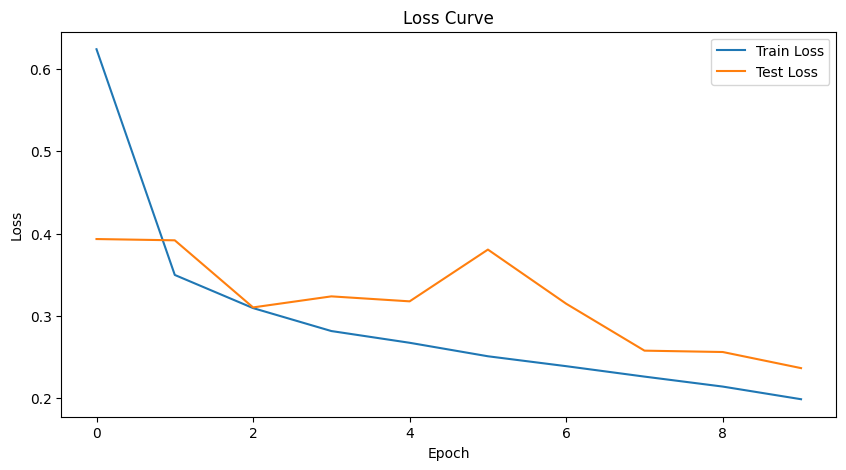

In [19]:
# Plot the training and test loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

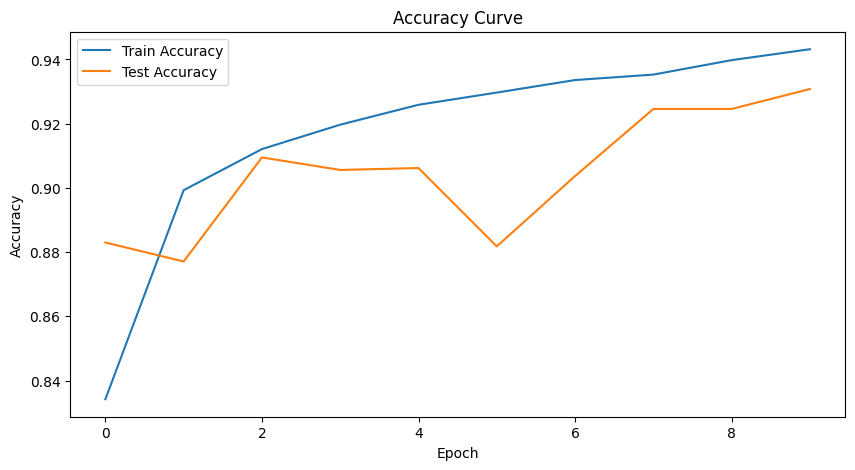

In [20]:
# Plot the training and test accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Plot some prediction

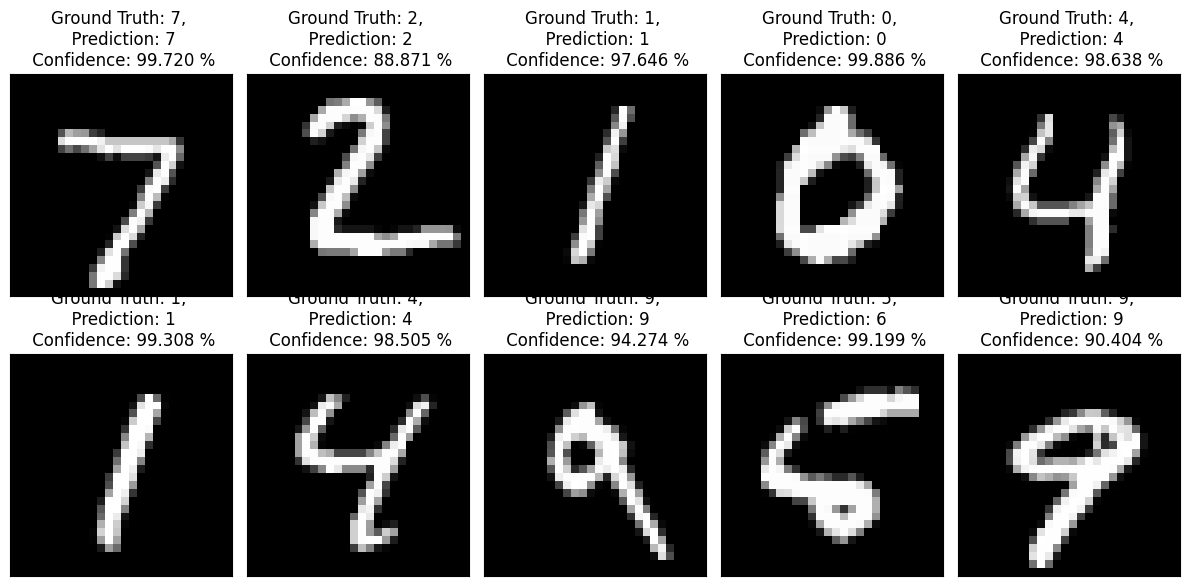

In [21]:
cnn_model.eval()
data, y = next(iter(test_loader))

# 1. push the data to the selected device
data, y = data.to(device), y.to(device)

# 2. feed the data into the model and the model makes predictions
_, logits = cnn_model(data)   # raw prediction before applying softmax ; unnormalised scores for each class

# 3. get the class with highest prob.
y_pred = torch.argmax(logits, 1) # finds the index of the class with the highest value (i.e., the predicted class) along dimension 1,

get_prob = torch.nn.Softmax(dim=1) # converts logits into probabilities that sums to 1
prob = get_prob(logits)            # prob is a tensor where each row corresponds to a sample, and each column contains the probability of that sample belonging to a particular class.

# Plot 
fig = plt.figure(figsize=(12,6))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(data[i].cpu().detach().numpy().reshape((28,28)), cmap='gray')
    
    # detach(): Detaches the tensor from the computation graph, so no gradients are tracked.
    # cpu(): Moves the tensor back to the CPU (important if you're using a GPU).
    # numpy(): Converts the tensor to a NumPy array.
    
    plt.title(f"Ground Truth: {y[i].cpu().detach().numpy()}, \n  Prediction: {y_pred[i].cpu().detach().numpy()} \n Confidence: {prob[i][y_pred[i]] * 100:.3F} %")
    plt.xticks([])
    plt.yticks([])
plt.tight_layout() # Adjusts the subplot parameters to make sure that subplots fit into the figure area nicely, avoiding overlaps.
plt.show()

### Visualize `filter weights`

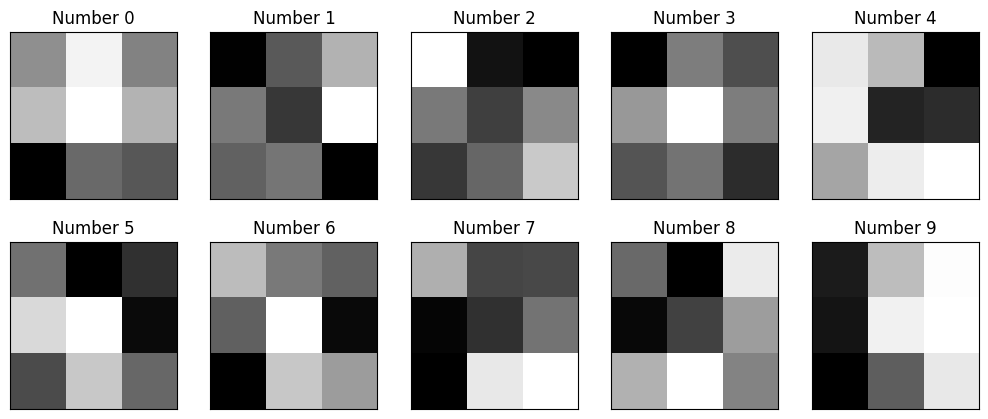

In [22]:
fig = plt.figure(figsize=[5*2.5, 2*2.5])
for i in range(10):                          # loops through first 10 filters,  Each filter corresponds to a learned weight matrix, which is applied to the input image.
  ax = fig.add_subplot(2, 5, i+1)
  # access the ith weight, reshapes to 3*3 matrix  
  ws = cnn_model.conv1.weight[i].reshape([3, 3]).cpu().detach().numpy() # Change here if your filter size is changed 
  ax.imshow(ws, cmap='gray')
  plt.title(f"Number {i}")
  plt.xticks([])
  plt.yticks([])

### Visualize `feature map`

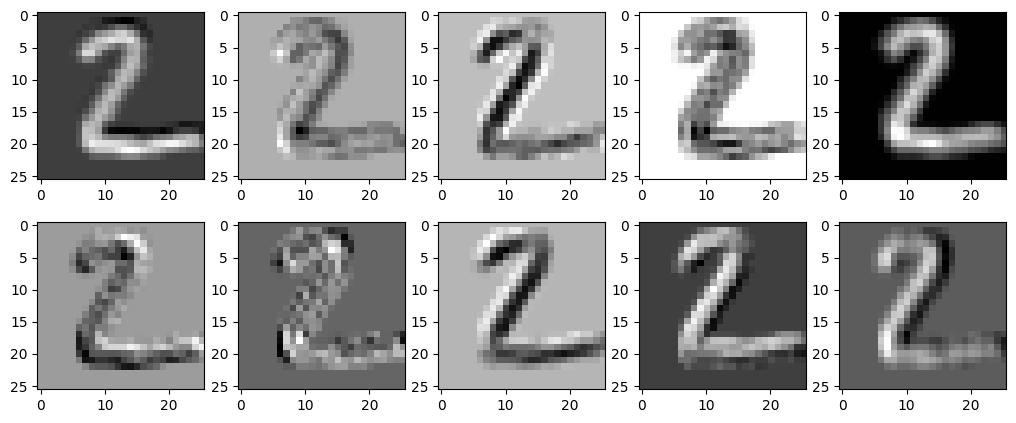

In [23]:
# Visualize feature maps
activation = {}         # initializes empty dictionary to store the feature maps

# returns a hook function,
def get_activation(name):
    # hook will capture the layer's output (output) and store it in the activation dictionary with the specified name.
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

cnn_model.conv1.register_forward_hook(get_activation('conv1')) # This line registers the hook on the first convolutional layer (conv1).
data, _ = test_ds[1]                                           # retrieves a single test sample from the dataset test_ds (data,label)
data.unsqueeze_(0)     # Since this is a single image, unsqueeze_(0) changes its shape from [1, 28, 28] to [1, 1, 28, 28], where 1 is the batch size
output = cnn_model(data.to(device))  # output is not required for this case since we stored activations

fm_cov1 = activation['conv1'].squeeze().cpu().detach().numpy()  # .squeeze(): Removes the extra batch dimension added earlier, so the feature map has the shape [out_channels, height, width].
fig = plt.figure(figsize=[5*2.5, 2*2.5])
for i in range(10):
  ax = fig.add_subplot(2, 5, i+1)
  ax.imshow(fm_cov1[i], cmap='gray')

# The feature maps are the result of applying the learned filters to the input image, so they represent specific patterns or structures detected by the filters. 

## Lets now try using RESNET18 model

- We can load a pretrained model on Imagenet dataset or train from scratch. For now we are using a pretrained model.

### Keypoints:

1. Customizing the Final Layer: Since ResNet-18's final fully connected (fc) layer is designed for ImageNet (1000 classes), we modify it to suit our dataset by setting resnet18.fc = nn.Linear(resnet18.fc.in_features, num_classes).

2. Transformations: The input image size for ResNet-18 is 224x224, so we resize the CIFAR-10 images (originally 32x32) using transforms.Resize(224).

3. Training and Testing: The model is trained using train_model and evaluated using test_model.

In [24]:
# Load ResNet-18 pre-trained model
from torchvision.models import ResNet18_Weights
resnet18 = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1) # or use .DEFAULT for the latest weights

# This code will raise the deprecation warning:
# model = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\eraco/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:02<00:00, 21.7MB/s]


In [25]:
# Modify the final layer to match the number of classes (for example, CIFAR-10 has 10 classes)
num_classes = 10
resnet18.fc = nn.Linear(resnet18.fc.in_features, num_classes)

In [26]:
# Transfer the model to the GPU if available
resnet18 = resnet18.to(device)

# Define transforms (resize to 224x224 since ResNet expects that input size)
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [27]:
# Download CIFAR-10 dataset (or use your own dataset)
train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)


# Subsample the training and test datasets

# Function to subsample CIFAR-10 dataset
def subsample_dataset(dataset, sample_size=1000):
    indices = np.random.choice(len(dataset), sample_size, replace=False)
    subset = Subset(dataset, indices)
    return subset

sample_size = 1000
train_subset = subsample_dataset(train_dataset, sample_size=sample_size)
test_subset = subsample_dataset(train_dataset, sample_size=int(sample_size * 0.4))

# Load the data
train_loader = torch.utils.data.DataLoader(dataset=train_subset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_subset, batch_size=64, shuffle=False)

100%|██████████| 170498071/170498071 [00:25<00:00, 6782280.71it/s]


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [28]:
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [29]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=0.001)

# Training function
def train_model(model, train_loader, criterion, optimizer, num_epochs=5):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

In [30]:
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    print(f'Accuracy of the model on the test images: {100 * correct / total:.2f}%')

In [31]:
# Training the model
train_model(resnet18, train_loader, criterion, optimizer, num_epochs=5)

Epoch [1/5], Loss: 1.3161
Epoch [2/5], Loss: 0.6639
Epoch [3/5], Loss: 0.3002
Epoch [4/5], Loss: 0.1784
Epoch [5/5], Loss: 0.0961


In [32]:
# Testing the trained model
test_model(resnet18, test_loader)

Accuracy of the model on the test images: 61.50%


## Fine-tuning vs. Feature Extraction

- **Fine-tuning**: During fine-tuning, you update the weights of **all layers** in the network during training. This is typically done when you want to adapt a pre-trained model to a new task. By default, when calling `optimizer.step()` on all parameters, the weights of all layers are updated.

- **Feature Extraction**: In feature extraction, you freeze the weights of the pre-trained layers and only train the final layer (or a few newly added layers). This allows the model to use the learned features from the pre-trained network while adjusting the output to the new task.

To freeze the layers in PyTorch, you can set the `requires_grad` attribute of the parameters to `False` like this:

```python
for param in resnet18.parameters():
    param.requires_grad = False


# Take Home Exercise

# Assignment: Custom CNN on MNIST Dataset

## Objective
In this assignment, you will implement and train a custom Convolutional Neural Network (CNN) to classify handwritten digits from the MNIST dataset.

---

## Task Breakdown

### Part 1: Data Preparation
1. **Load and Visualize Data**: 

   - Load the MNIST dataset using PyTorch’s `torchvision.datasets` and visualize some sample images along with their labels.
   
   - **Deliverable**: Submit a grid of at least 25 sample images and their respective labels from the MNIST dataset.

### Part 2: Custom CNN Implementation
1. **Define Your CNN Model**:

   - Implement a custom CNN class using PyTorch’s `torch.nn.Module`. The network should consist of:
   
     - 2 convolutional layers
     - 2 max-pooling layers
     - At least 1 fully connected layer
     - Use ReLU activations and appropriate dropout layers.

   **Hints**:
   
   - First conv layer: Input channels = (grayscale image), Output channels = 16, Kernel size = 3x3.
   - Second conv layer: Output channels = 32, Kernel size = 3x3.
   - Max-pooling layers with 2x2 window.

   **Deliverable**: Submit your `MyCNN` class code.

### Part 3: Model Training and Evaluation

1. **Training the Model**:
   - Train the CNN on the MNIST training set.
   - Use Cross-Entropy Loss and an optimizer (e.g., SGD or Adam).
   - Plot the training and validation loss curves over 10-20 epochs.

   **Deliverable**: Submit code for training and a plot showing the loss curves.

2. **Accuracy Evaluation**:
   - Evaluate the model on the MNIST test set and report the accuracy.

   **Deliverable**: Submit the final accuracy on the test set.

### Part 4: Visualization
1. **Feature Map Visualization**:
   - Register a forward hook on the second convolutional layer to capture the feature maps.
   - Plot the feature maps for a few random test images (at least 3 different digits).

   **Deliverable**: Submit code and images showing feature maps from the second convolutional layer.

---

## Submission Requirements
- Submit a Jupyter Notebook with the following sections:
  1. Data Loading and Visualization
  2. CNN Model Implementation
  3. Training and Loss Curves
  4. Final Test Accuracy
  5. Feature Map Visualizations

## Evaluation Criteria
- Correctness and clarity of the CNN implementation.
- Proper visualizations of data, loss and accuracy curves, and feature maps.